# RGBA vs One-Hot Encoded

In [1]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'ae.conv.onehot'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = '../artifacts/pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 10
LR = 1e-03
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: ../artifacts/pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)


# Training

In [8]:
model = M.ae.ConvOneHotAutoencoder()
criterion = torch.nn.CrossEntropyLoss()

train_losses, test_losses = M.ae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)

M.save(SAVE_NAME, model, train_losses, test_losses)



INFO | model: pallets.models.ae.ConvOneHotAutoencoder
INFO | criterion: torch.nn.modules.loss.CrossEntropyLoss
INFO | learn rate: 0.001
INFO | epochs: 10
INFO | epoch 1 (  0%) loss: 2.698054
INFO | epoch 1 ( 35%) loss: 0.918165
INFO | epoch 1 ( 70%) loss: 0.619728
INFO | epoch 1 (100%) loss: 0.489733
INFO | epoch 1 (test) loss: 0.030365
INFO | epoch 2 (  0%) loss: 0.125955
INFO | epoch 2 ( 35%) loss: 0.083989
INFO | epoch 2 ( 70%) loss: 0.060270
INFO | epoch 2 (100%) loss: 0.049012
INFO | epoch 2 (test) loss: 0.003876
INFO | epoch 3 (  0%) loss: 0.011838
INFO | epoch 3 ( 35%) loss: 0.012119
INFO | epoch 3 ( 70%) loss: 0.010054
INFO | epoch 3 (100%) loss: 0.008569
INFO | epoch 3 (test) loss: 0.000998
INFO | epoch 4 (  0%) loss: 0.004368
INFO | epoch 4 ( 35%) loss: 0.003362
INFO | epoch 4 ( 70%) loss: 0.002907
INFO | epoch 4 (100%) loss: 0.002594
INFO | epoch 4 (test) loss: 0.000367
INFO | epoch 5 (  0%) loss: 0.000829
INFO | epoch 5 ( 35%) loss: 0.001306
INFO | epoch 5 ( 70%) loss: 0.00

# Results

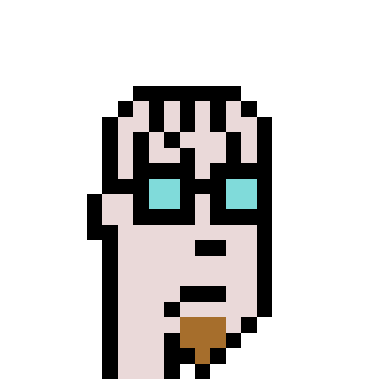

In [9]:
punk, _ = next(iter(train_loader))
reconstructed = model(punk.to(device))
reconstructed = reconstructed.detach().cpu()
some_image = reconstructed[22]

some_image = DS.one_hot_to_rgba(some_image, mapper)

pil_image = to_pil_image(some_image.clone().detach())
plt.imshow(pil_image)
plt.axis('off')
plt.show()

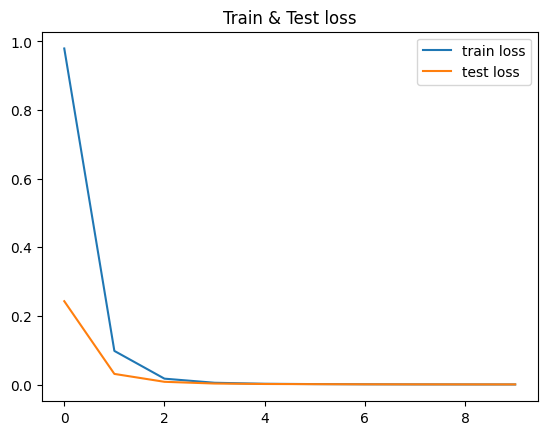

In [10]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()